## Does the CMIP5 emergent constraint on SH jet shifts work in CMIP6?

Kidston and Gerber (2010) (https://doi.org/10.1029/2010GL042873) demonstrated in the annual mean that there was a relationship between the SH climatological jet latitude in the present day and how much the SH jet latitude shifted further poleward under anthropogenic climate change.  Suggesting that there is an emergent constraint on the SH jet latitude change i.e., we know where the real worl jet latitude is and we can use the inter-model relationship between jet latitude and jet shift, to predict where the real world jet will shift in the future.  This relationship was further demonstrated by Simpson and Polvani (https://doi.org/10.1002/2016GL067989) to have a strong seasonality, with the emergent constraint only being strong in the SH winter (JJA).

<img src="simpsonandpolvani.png">

In [1]:
# Loading libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import dask
import season_util as su
import jetlatcalcs as jlat
import intake

you have successfully imported the jet latitude calculation subroutines


In [2]:
from ncar_jobqueue import NCARCluster
from distributed import Client
cluster = NCARCluster(project='UCGD0006')
cluster.adapt(minimum_jobs=1, maximum_jobs=10)
client = Client(cluster)
cluster

In [3]:
models=['AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1',
       'CAMS-CSM1-0','CanESM5','CNRM-CM6-1','CNRM-ESM2-1','E3SM-1-0',
       'MIROC6','IPSL-CM6A-LR',
       'HadGEM3-GC31-LL','UKESM1-0-LL','MRI-ESM2-0',
       'GISS-E2-1-G','GISS-E2-1-H','CESM2','CESM2-WACCM',
       'NorESM2-LM','GFDL-AM4','GFDL-ESM4','SAM0-UNICON']

#model = ['IPSL-CM6A-LR','CanESM5']

var = ["ua"]
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/\
intake-esm-datastore/catalogs/glade-cmip6.json")
cat = col.search(activity_id="CMIP",experiment_id="piControl",
                variable_id=var, table_id="Amon", source_id=models)
cat4x = col.search(activity_id="CMIP",experiment_id="abrupt-4xCO2",
                variable_id=var, table_id="Amon", source_id=models)
dset_dict_pi = cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}, 
                                    'decode_times': True})
dset_dict_4x = cat4x.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}, 
                                    'decode_times': True})
cat4x.df.head()

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 20 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 20 group(s)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
18037,CMIP,CNRM-CERFACS,CNRM-CM6-1,abrupt-4xCO2,r3i1p1f2,Amon,ua,gr,NaN,v20181012,185005-185912,/glade/collections/cmip/CMIP6/CMIP/CNRM-CERFAC...
18262,CMIP,CNRM-CERFACS,CNRM-CM6-1,abrupt-4xCO2,r4i1p1f2,Amon,ua,gr,NaN,v20181012,185007-185912,/glade/collections/cmip/CMIP6/CMIP/CNRM-CERFAC...
18628,CMIP,CNRM-CERFACS,CNRM-CM6-1,abrupt-4xCO2,r1i1p1f2,Amon,ua,gr,NaN,v20180705,185001-199912,/glade/collections/cmip/CMIP6/CMIP/CNRM-CERFAC...
18854,CMIP,CNRM-CERFACS,CNRM-CM6-1,abrupt-4xCO2,r5i1p1f2,Amon,ua,gr,NaN,v20181012,185009-185912,/glade/collections/cmip/CMIP6/CMIP/CNRM-CERFAC...
19078,CMIP,CNRM-CERFACS,CNRM-CM6-1,abrupt-4xCO2,r2i1p1f2,Amon,ua,gr,NaN,v20181012,185003-185912,/glade/collections/cmip/CMIP6/CMIP/CNRM-CERFAC...


Note, currently all models piControls start in January.  This is going to fail for a model where that's not the case e.g., often the met office.  We need to do something fancier here to make sure it works more generally

In [4]:
#calculate the mean over longitude, ensemble members and desired time period and pick out 700hPa
pi_mean = {}
abrupt4x_mean = {}
for key, ds in dset_dict_pi.items():
    pi_mean[key] = ds.isel(time = slice(0,100*12))
    pi_mean[key] = pi_mean[key].sel(plev=70000.).mean(dim=["member_id","lon"])
for key, ds in dset_dict_4x.items():
    abrupt4x_mean[key] = ds.isel(time = slice(50*12,150*12))
    abrupt4x_mean[key] = abrupt4x_mean[key].sel(plev=70000.).mean(dim=["member_id","lon"])

In [ ]:
print(abrupt4x_mean)

In [6]:
pi_mean = dask.compute(pi_mean)
abrupt4x_mean = dask.compute(abrupt4x_mean)

In [7]:
# calculate JJA season average
#xr.Dataset.drop(dset_dict_pi["CMIP.IPSL.IPSL-CM6A-LR.piControl.Amon.gr"])
#del dset_dict_pi["CMIP.MRI.MRI-ESM2-0.piControl.Amon.gn"]
#del dset_dict_4x["CMIP.MRI.MRI-ESM2-0.abrupt-4xCO2.Amon.gn"]
import pandas as pd
pi_jja = {}
for key, x in dset_dict_pi.items():
    print(key)
    try:
        pi_jja[key] = su.season_mean(pi_mean[0][key],"ua",season="JJA")
    except:
        pi_mean[0][key]["time"]=pd.date_range(pi_mean[0][key].time[0].values, pd.date_range(pi_mean[0][key].time[-1].values, periods=1,freq='M').values[-1], freq='M')
        pi_jja[key] = su.season_mean(pi_mean[0][key],"ua",season="JJA")

abrupt4x_jja = {}
for key, x in dset_dict_4x.items():
    
    try:
        abrupt4x_jja[key] = su.season_mean(abrupt4x_mean[0][key],"ua",season="JJA")
    except:
        abrupt4x_mean[0][key]["time"]=pd.date_range(abrupt4x_mean[0][key].time[0].values, pd.date_range(abrupt4x_mean[0][key].time[-1].values, periods=1,freq='M').values[-1], freq='M')
        abrupt4x_jja[key] = su.season_mean(abrupt4x_mean[0][key],"ua",season="JJA")
        

CMIP.AWI.AWI-CM-1-1-MR.piControl.Amon.gn
CMIP.BCC.BCC-CSM2-MR.piControl.Amon.gn
CMIP.BCC.BCC-ESM1.piControl.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.piControl.Amon.gn
CMIP.CCCma.CanESM5.piControl.Amon.gn
CMIP.CNRM-CERFACS.CNRM-CM6-1.piControl.Amon.gr
CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.Amon.gr
CMIP.E3SM-Project.E3SM-1-0.piControl.Amon.gr
CMIP.IPSL.IPSL-CM6A-LR.piControl.Amon.gr
CMIP.MIROC.MIROC6.piControl.Amon.gn
CMIP.MOHC.HadGEM3-GC31-LL.piControl.Amon.gn
CMIP.MOHC.UKESM1-0-LL.piControl.Amon.gn
CMIP.MRI.MRI-ESM2-0.piControl.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G.piControl.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-H.piControl.Amon.gn
CMIP.NCAR.CESM2.piControl.Amon.gn
CMIP.NCAR.CESM2-WACCM.piControl.Amon.gn
CMIP.NCC.NorESM2-LM.piControl.Amon.gn
CMIP.NOAA-GFDL.GFDL-ESM4.piControl.Amon.gr1
CMIP.SNU.SAM0-UNICON.piControl.Amon.gn


/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean 

In [8]:
#calculate jet latitude
jlathist = {}
jspeedhist = {}
for key, x in dset_dict_pi.items():
    jlatv, jspeedv = jlat.calcjetlat( pi_jja[key], -80, -20)
    jlathist[key] = jlatv
    jspeedhist[key] = jspeedv
    
jlatssp370 = {}
jspeedssp370 = {}
for key, x in dset_dict_4x.items():
    jlatv, jspeedv = jlat.calcjetlat( abrupt4x_jja[key], -80, -20)
    jlatssp370[key] = jlatv
    jspeedssp370[key] = jspeedv

In [9]:
#read in cmip5 data
cmip5path = "cmip5_jetlatitudes_pi4xco2.nc"
cmip5 = xr.open_dataset(cmip5path)
#calculate linear regression line
coefs = np.polyfit(cmip5.jlatpi, cmip5.jlat4x - cmip5.jlatpi, 1)
acmip5=coefs[1]
bcmip5=coefs[0]
xvalues = [i for i in range(-55,-35)]
yvalues = [acmip5 + bcmip5*i for i in xvalues]

In [10]:
#predict cmip6 values from cmip5
jlathistvalues = list(jlathist.values())
ycmip6 = [acmip5 + bcmip5*i for i in jlathistvalues]
ycmip6

[-1.2244194094357326,
 -1.3115047674596276,
 -1.4799173518491173,
 -3.4235733009761553,
 -2.5758506426250385,
 -3.329880654138755,
 -4.28371573770465,
 -1.473055815540942,
 -2.0816158124754764,
 -5.9437001481901675,
 -2.274231282271302,
 -2.617746949179203,
 -3.686959808813789,
 -1.4301178203745373,
 -0.8465644219171153,
 -1.0928331012976287,
 -0.9757829809847003,
 -0.16005823285016518,
 -3.030858228196788,
 -0.1286534035571023]

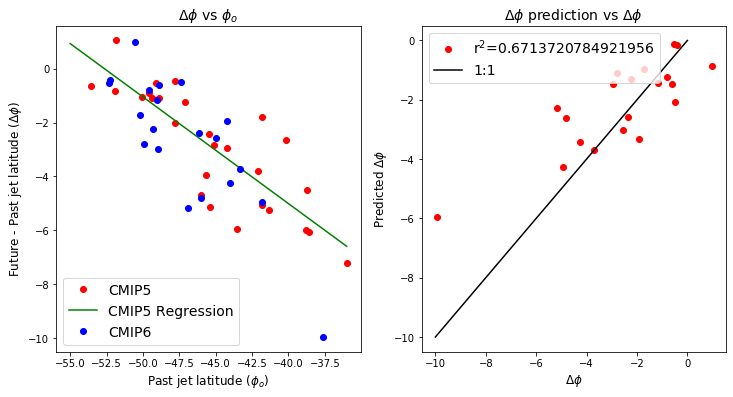

In [11]:
# plotting
jlathistvalues = list(jlathist.values())
jlatssp370values = list(jlatssp370.values())
jlatdif = [a - b for a, b in zip(jlatssp370values, jlathistvalues)]
jlatdifpredict = [acmip5 + bcmip5*i for i in jlathistvalues]
fig = plt.figure(figsize=(12, 6),facecolor='w')
ax = fig.add_subplot(1, 2, 1)
#ax.plot(jlathistvalues,jlatdif, color='red', label='CMIP6', marker='o', linestyle='none')
ax.plot(cmip5.jlatpi, cmip5.jlat4x-cmip5.jlatpi, color='red', label='CMIP5', marker='o', linestyle='none')
ax.plot(xvalues,yvalues,color='green', label='CMIP5 Regression', linestyle='solid')
ax.plot(jlathistvalues,jlatdif, color='blue', label='CMIP6', marker='o', linestyle='none')
ax.set_xlabel('Past jet latitude ($\phi_{o}$)', fontdict={'size':12});
ax.set_ylabel('Future - Past jet latitude ($\Delta\phi$)', fontdict={'size':12});  
ax.set_title('$\Delta\phi$ vs $\phi_{o}$', fontdict={'size':14})
ax.legend(loc='lower left', fontsize=14)


r = np.corrcoef(jlatdif,jlatdifpredict)
r=r[0,1]
rsq = r**2

ax2=fig.add_subplot(1,2,2)
ax2.plot(jlatdif, jlatdifpredict, color='red', label='r$^{2}$='+str(rsq), marker='o', linestyle='none')
ax2.set_xlabel('$\Delta\phi$', fontdict={'size':12})
ax2.set_ylabel('Predicted $\Delta\phi$', fontdict={'size':12})
ax2.plot([-10,0],[-10,0], color='black', label='1:1', linestyle='solid')
ax2.set_title('$\Delta\phi$ prediction vs $\Delta\phi$', fontdict={'size':14})
ax2.legend(loc='upper left', fontsize=14)
